# This is a short notebook where we define and run an algorithm simulating the invasion of a population of species X by a population of species Y.

## First, we import the required libraries

In [1]:
import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
from copy import deepcopy

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals

## Then we define the "invasion" function

In [22]:
# create output path
output_dir = "output_1"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Y_tot
        for t, y in zip(sol.t, sol.y.sum(axis=0)):
            resY.write(f"{t:.3f} {y:.3f}\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival


## Now, we define parameters and run the code itself

In [23]:
# Define parameters
ttot1 = 200.0  # Total simulation time
dt1 = 1.0E-3  # Timestep
REALIZATIONS1 = 10  # Number of simulation runs
N_X1 = 3  # Number of original species
N_Y1 = 3  # Number of invaders
N_RY1 = 4  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival = invasion_thermo(N_X = N_X1, N_Y = N_Y1, N_RY = N_RY1, ttot = ttot1, dt = dt1, REALIZATIONS = REALIZATIONS1, diluted = True, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
   1  2  3  4
1 -1  0  0 -1
2  0  0  0  0
3  1  0  0  0
4 -1  1 -1  1
5  0 -1  1 -1
6  1  1  1  0
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 1:
   1  2  3  4
1 -1  0  1  0
2  0 -1 -1 -1
3  0  1  0  0
4  1  1 -1 -1
5 -1 -1  0  0
6  1  0  1  1
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 2:
   1  2  3  4
1  1  0  0  0
2  0  0  0  0
3 -1  0  0  0
4  1  1  1  1
5  0 -1 -1 -1
6 -1  0  0  1
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 3:
   1  2  3  4
1  0  0  0  0
2  0  0 -1  0
3 -1  0

## Finally, we plot all the time series

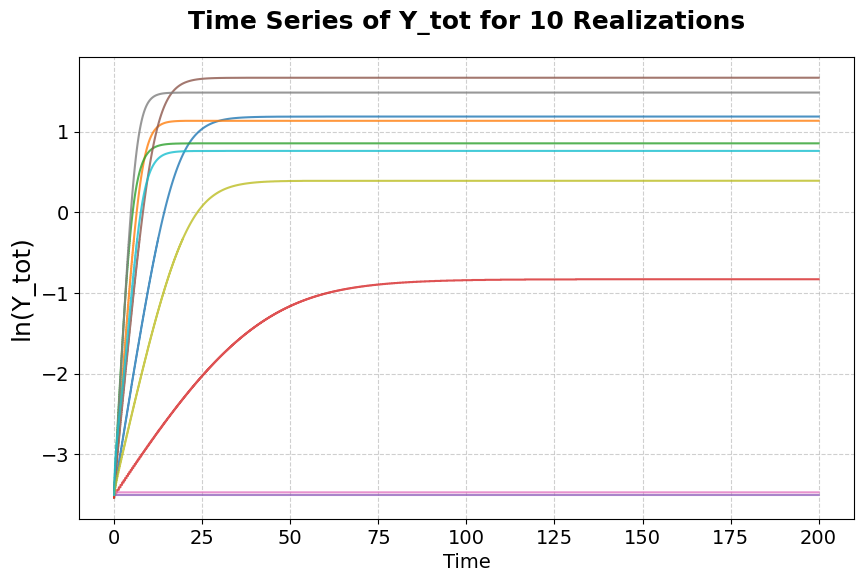

In [11]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each file and plot its time series
for file in file_list:
    # Read the data
    data = pd.read_csv(file, delimiter=' ', header=None, names=['Time', 'Y_tot'])
    
    # Plot each realization
    plt.plot(data['Time'], np.log(data['Y_tot']), linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title(f'Time Series of Y_tot for {len(file_list)} Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y_tot)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



# Change Parameter (non-dilute)

In [24]:
# create output path
output_dir = "output_2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def invasion_thermo(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 
        
        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Y_tot
        for t, y in zip(sol.t, sol.y.sum(axis=0)):
            resY.write(f"{t:.3f} {y:.3f}\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        resY.close()
        

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival


In [26]:
# Define parameters
ttot2 = 200.0  # Total simulation time
dt2 = 1.0E-3  # Timestep
REALIZATIONS2 = 10  # Number of simulation runs
N_X2 = 3  # Number of original species
N_Y2 = 3  # Number of invaders
N_RY2 = 4  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival2 = invasion_thermo(N_X = N_X2, N_Y = N_Y2, N_RY = N_RY2, ttot = ttot2, dt = dt2, REALIZATIONS = REALIZATIONS2, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
   1  2  3  4
1 -1  0  0 -1
2  0  0 -1  0
3  0  0  0  0
4  1 -1  1 -1
5  0  1  1  1
6 -1 -1 -1  0
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 1:
   1  2  3  4
1  0  0  0  0
2  0  0  0 -1
3  0  0  0  0
4  1  1  0 -1
5 -1  1  1  2
6  1 -1 -1  0
#Species:  6 # Reactions:  4
#Species:  6 # Reactions:  4
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  1 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set ['C_2']
	 Waste Set ['C_6']
	 Extra M in AC:  []
	 Species in AC:  ['C_4', 'C_5']
	 Reactions in AC:  ['R1', 'R4']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R1: C_5 ->C_4+C_6
			 R4: C_2+C_4 ->2C_5
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 1
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
X MAINTAINS

Invaded!!!

Matrix Stot 2:
   1  2  3  4
1  1 -1  0

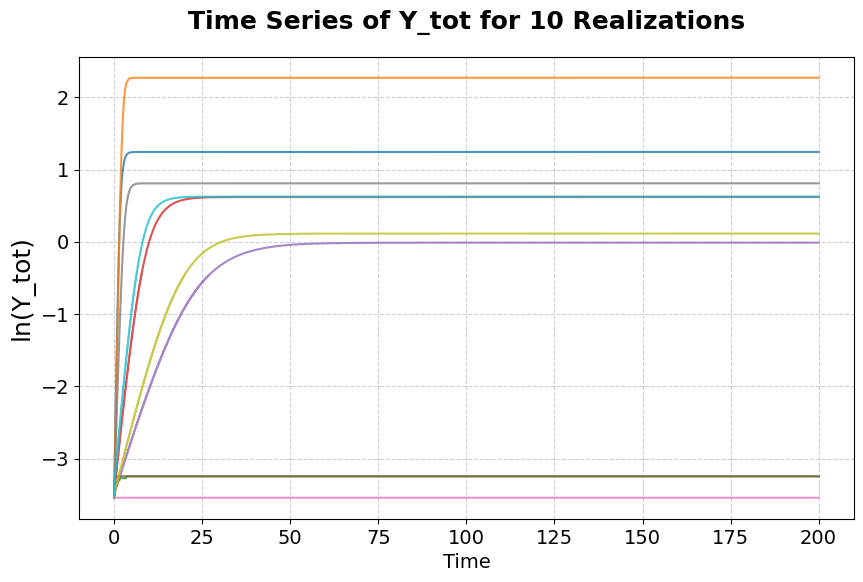

In [27]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

      # file_list.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))  # Sort by realization number

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each file and plot its time series
for file in file_list:
    # Read the data
    data = pd.read_csv(file, delimiter=' ', header=None, names=['Time', 'Y_tot'])
    
    # Plot each realization
    plt.plot(data['Time'], np.log(data['Y_tot']), linewidth=1.5, alpha=0.8)

# Add title and labels
plt.title(f'Time Series of Y_tot for {len(file_list)} Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y_tot)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



# Study Single Realization

In [62]:
# create output path
output_dir = "output_single2"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        resY.truncate(0)
        resSp.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        
        def dydt(t, Y):
            nonlocal X_values 
            X_values.append(X.copy()) # record X
            
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term
                
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values) 

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" + "," +",".join(f"{y:.3f}" for y in y_values) + "\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        resY.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [60]:
# Define parameters
ttot3 = 200.0  # Total simulation time
dt3 = 1.0E-3  # Timestep
REALIZATIONS3 = 1  # Number of simulation runs
N_X3 = 5  # Number of original species
N_Y3 = 5  # Number of invaders
N_RY3 = 4  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival3 = Single_Invasion(N_X = N_X3, N_Y = N_Y3, N_RY = N_RY3, ttot = ttot3, dt = dt3, REALIZATIONS = REALIZATIONS3, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4
1   0  0  0  0
2   0  0  1  0
3   0  0  0  1
4   0  1  0  0
5   0 -1  0  0
6   0 -1  0  0
7  -1  0  1  1
8   1  1  0  0
9   0  0 -1  0
10 -1  0  0 -1
#Species:  10 # Reactions:  4
#Species:  10 # Reactions:  4
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n5.xlsx
X MAINTAINS

NOT-Invaded

0/1 Realizations led to successful invasion


(200000, 6)
       0     1      2     3     4     5
0  0.000  0.01  0.010  0.01  0.01  0.01
1  0.001  0.01  0.010  0.01  0.01  0.01
2  0.002  0.01  0.010  0.01  0.01  0.01
3  0.003  0.01  0.010  0.01  0.01  0.01
4  0.004  0.01  0.011  0.01  0.01  0.01


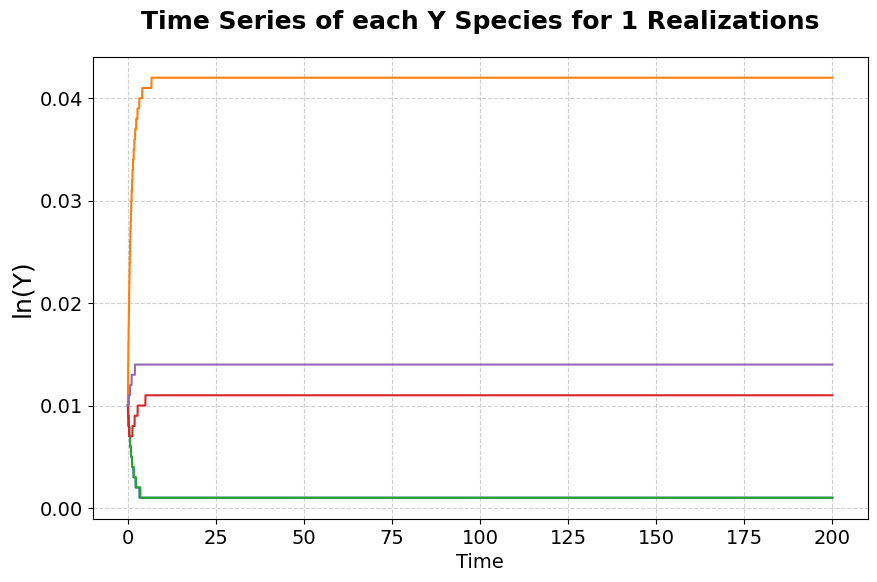

In [61]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")

data = pd.read_csv('C:/Users/Lenovo/Desktop/Invader Coding/output_single/Time_1.dat', header=None)
print(data.shape)

print(data.head())

# Extract Time
time = data.iloc[:, 0]

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each species and plot its time series
for i in range(1, data.shape[1]):  
    plt.plot(time, data.iloc[:, i], label=f"Y{i}")
        

# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [63]:
# Define parameters
ttot3 = 200.0  # Total simulation time
dt3 = 1.0E-3  # Timestep
REALIZATIONS3 = 1  # Number of simulation runs
N_X3 = 5  # Number of original species
N_Y3 = 5  # Number of invaders
N_RY3 = 5  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival3 = Single_Invasion(N_X = N_X3, N_Y = N_Y3, N_RY = N_RY3, ttot = ttot3, dt = dt3, REALIZATIONS = REALIZATIONS3, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4  5
1   0  0  0  0 -1
2   0  0  0  0  0
3   0 -1 -1  0  0
4   0  0  0 -1  0
5   0  0  0  0  0
6   1  1  1  0 -1
7  -1  0  0 -1  1
8   0  0  0  0  0
9   0  0  0  0  1
10  0 -1 -1  2  0
#Species:  10 # Reactions:  5
#Species:  10 # Reactions:  5
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  3 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C', 'C_3', 'C_4']
	 Waste Set ['C_9']
	 Extra M in AC:  []
	 Species in AC:  ['C_6', 'C_7', 'C_10']
	 Reactions in AC:  ['R2', 'R4', 'R5']
	 Flow:  [0.01] --> Production:  [0.01, 0.0, -0.01]
			 R2: C_3+C_10 ->C_6
			 R4: C_4+C_7 ->2C_10
			 R5: C+C_6 ->C_7+C_9
	 - CPU Time: 0.00 secs
**** Sol 2: 3 reactions
	 #Species:  3 #FoodSet:  3 #WasteSet:  1 #ExtraMembersSet:  0 #Reactions:  3
	 Food Set ['C', 'C_3', 'C_4']
	 Waste Set ['C_9']
	 Extra M in AC:  []
	 Species in AC:  ['C_6', 'C_7', 'C_10']
	 Reactions in AC:  ['R3', 'R4', 'R5']
	 Flow:  [0.01] --> Production:  [0.0

(200000, 6)
       0     1     2     3     4     5
0  0.000  0.01  0.01  0.01  0.01  0.01
1  0.001  0.01  0.01  0.01  0.01  0.01
2  0.002  0.01  0.01  0.01  0.01  0.01
3  0.003  0.01  0.01  0.01  0.01  0.01
4  0.004  0.01  0.01  0.01  0.01  0.01


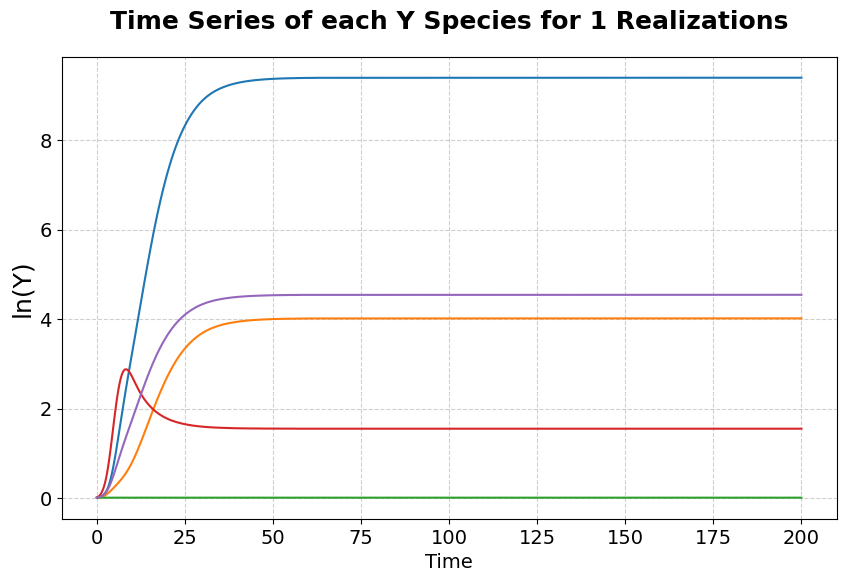

In [64]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")

data = pd.read_csv('C:/Users/Lenovo/Desktop/Invader Coding/output_single2/Time_1.dat', header=None)
print(data.shape)

print(data.head())

# Extract Time
time = data.iloc[:, 0]

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each species and plot its time series
for i in range(1, data.shape[1]):  
    plt.plot(time, data.iloc[:, i], label=f"Y{i}")
        

# Add title and labels
plt.title(f'Time Series of each Y Species for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Y)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Energy Flow

In [22]:
# create output path
output_dir = "output_singleaff"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Affinity(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        resY.truncate(0)
        resSp.truncate(0)
        resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        Aff_values = []
        
        def dydt(t, Y):
            nonlocal X_values
            nonlocal Aff_values
            X_values.append(X.copy()) # record X
            Aff = np.zeros(N_RY) # record Affinity
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term

                # Affinity
                if rater[l] != 0:
                   Aff[l] = np.log(ratef[l]/rater[l])
                else:
                   Aff[l] = np.nan

            
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            Aff_values.append(Aff.copy())

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)

        Aff_values = np.array(Aff_values)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        resY.close()
        resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [2]:
# create output path
output_dir = "output_singleaff1"

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

def Single_Invasion_Affinity(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy, degradation):
    """
    Simulates the invasion of a dynamical system by additional species.
    
    Parameters:
    - N_X: Number of species in the original system
    - N_Y: Number of invading species
    - N_RY: Number of reactions involving invaders
    - ttot: Total simulation time
    - dt: Time step for integration
    - REALIZATIONS: Number of simulation runs
    - diluted: Whether invaders interact with the original species
    - ambiguity: Allows for flexible reaction assignments
    - law: Defines reaction kinetics (e.g., Michaelis-Menten)
    - autonomy: If invaders can react among themselves
    - degradation: Whether degradation terms are included
    
    Returns:
    - survival: List indicating if invaders successfully grew in each realization
    """

    npas = int(ttot / dt)  # Number of time steps
    survival = []
    compt = 0  # Count of successful invasions

    # Ensure consistency in conditions
    if diluted and not autonomy:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return survival

    # Clean previous output files
    for f in os.listdir(output_dir):
        path = os.path.join(output_dir, f)
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.unlink(path)

    # Iterate over multiple realizations
    for r in range(REALIZATIONS):
        resY = open(os.path.join(output_dir, f"Time_{r + 1}.dat"), "w")
        resSp = open(os.path.join(output_dir, f"Stoichio_{r + 1}.dat"), "w")
        resAff = open(os.path.join(output_dir, f"Affinity_{r + 1}.dat"), "w")
        resY.truncate(0)
        resSp.truncate(0)
        resAff.truncate(0)

        # Initialize species concentrations and reaction rates
        S = np.zeros((N_X + N_Y, N_RY))
        S1 = np.zeros((N_X + N_Y, N_RY))
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
        kf = [random.uniform(1.95, 2.05) for _ in range(N_RY)]
        mu_0 = [random.uniform(-1, 1) for _ in range(N_X + N_Y)]

        # Construct stoichiometric matrix and reaction rates
        for i in range(N_RY):
            species1 = random.randint(0, N_Y - 1)
            S[N_X + species1][i] += 1
            
            if autonomy:
                species2 = random.randint(0, N_Y - 1)
                while not ambiguity and species2 == species1:
                    species2 = random.randint(0, N_Y - 1)
                S1[N_X + species2][i] += 1
                
            # The order of a chemical reaction
            total_order_for = random.randint(1, 2)
            total_order_bac = random.randint(1, 2)
            # Count the number of forward/backward reaction species already in the reaction
            stoichio_for = 0
            stoichio_bac = 0

            while stoichio_for < total_order_for - 1:
                # when not diluted, we count in N_Y
                species = random.randint(0, N_X + (N_Y if not diluted else 0) - 1)
                if ambiguity or S1[species][i] == 0:
                    S[species][i] += 1
                    stoichio_for += 1

            while stoichio_bac < (total_order_bac - (1 if autonomy else 0)):
                species = random.randint(0, N_X + N_Y - 1)
                if ambiguity or S[species][i] == 0:
                    S1[species][i] += 1
                    stoichio_bac += 1

        # Compute the total change in chemical potential
        Stot = S1 - S
        mu_0_vector = np.array(mu_0).reshape(-1, 1)
        DeltaG0 = np.dot(S1.T, mu_0_vector).flatten() - np.dot(S.T, mu_0_vector).flatten()
        kr = kf * np.exp(DeltaG0)

        # degradation coefficient
        kd = 0.01*np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])
        # try to change some forms


        df_S = pd.DataFrame(Stot, dtype=int)
        df_S.index = range(1, df_S.shape[0] + 1)
        df_S.columns = range(1, df_S.shape[1] + 1)
        print(f"Matrix Stot {r}:")
        print(df_S)
        auto(Stot,N_Y)

        # Print stoichiometric equations and ΔG expressions for verification
        # for i in range(N_RY):
        #     reactants = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0])
        #     products = " + ".join([f"X{j+1}" if j < N_X else f"Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr = " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S1[j, i] > 0])
        #     delta_g_expr += " - (" + " + ".join([f"mu_X{j+1}" if j < N_X else f"mu_Y{j-N_X+1}" for j in range(N_X + N_Y) if S[j, i] > 0]) + ")"
        #     print(f"Reaction {i+1}: {reactants} -> {products}")
        #     print(f"ΔG = {delta_g_expr}")
        #     print(f"Numerical ΔG = {DeltaG0[i]:.3f}\n")

        
        # Define ODE system
        X_values = []
        Aff_values = []
        
        def dydt(t, Y):
            nonlocal X_values
            nonlocal Aff_values
            X_values.append(X.copy()) # record X
            Aff = np.zeros(N_RY) # record Affinity
            curr = np.zeros(N_RY)
            ratef = np.ones(len(kf)) if law == "MM" else kf[:]
            rater = deepcopy(kr)
            X_Y = np.concatenate((X, Y))

            for l in range(N_RY):
                # forward reaction rate
                prod = 1
                for s, p in zip(X_Y, S[:, l]):
                    prod *= pow(s, p)
                if law == "MM":
                    ratef[l] = prod / (kf[l] + prod)
                else:
                    ratef[l] *= prod
                # backward reaction rate
                for s, p in zip(X_Y, S1[:, l]):
                    prod_term = pow(s, p)
                    # Prevent overflow by checking limits
                    if prod_term > 1e10: # reasonable?
                        prod_term = 1e10
                    rater[l] *= prod_term

                # Affinity
                if rater[l] != 0:
                   Aff[l] = np.log(ratef[l]/rater[l])
                else:
                   Aff[l] = np.nan

            
        
                # Safe subtraction with check for NaN or Inf
                curr[l] = ratef[l] - rater[l]

                # Add a small epsilon to avoid subtracting zero or negative small values
                if np.isnan(curr[l]) or np.isinf(curr[l]):
                    curr[l] = 0.0

            Aff_values.append(Aff.copy())

            # Add degradation term if enabled
            if degradation:
               degradation_term = kd * Y
               # Ensure no negative or zero values
               degradation_term = np.maximum(degradation_term, 0)  # Clip to prevent negative values
               curr -= degradation_term

            return np.dot((S1 - S)[N_X:, :], curr)


        # Solve the system of differential equations
        sol = solve_ivp(dydt, [0, ttot], Y, method='LSODA', t_eval=np.linspace(0, ttot, npas),
                        rtol=1e-3, atol=1e-6)  # Relaxed tolerances

        X_values = np.array(X_values)

        Aff_values = np.array(Aff_values)

        if np.all(X_values == X_values[0, :]):
           print("X MAINTAINS\n")
        else:
           print("!X CHANGED!\n")

        # Write the full time series of Single Y species
        for t, y_values in zip(sol.t, sol.y.T):
            resY.write(f"{t:.3f}" +",".join(f"{y:.3f}" for y in y_values) + "\n")

        # Write the full time series of Affinity in each reaction
        for t, aff_values in zip(sol.t, Aff_values):
            resAff.write(f"{t:.3f}," + ",".join(f"{aff:.3f}" for aff in aff_values) + "\n")
        
        # Determine survival based on final Y concentrations
        if sum(sol.y[:, -1]) >= 0.2:
            compt += 1
            print("Invaded!!!\n")
            resSp.write("INVADERS GREW\n")
            survival.append(True)
        else:
            resSp.write("INVADERS DIDN'T GROW\n")
            print("NOT-Invaded\n")
            survival.append(False)

        resSp.close()
        resY.close()
        resAff.close()

    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")
    return survival

In [7]:
# Define parameters
ttot4 = 200.0  # Total simulation time
dt4 = 1.0E-3  # Timestep
REALIZATIONS4 = 1  # Number of simulation runs
N_X4 = 5  # Number of original species
N_Y4 = 5  # Number of invaders
N_RY4 = 8  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff = Single_Invasion_Affinity(N_X = N_X4, N_Y = N_Y4, N_RY = N_RY4, ttot = ttot4, dt = dt4, REALIZATIONS = REALIZATIONS4, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1  2  3  4  5  6  7  8
1   0  1  0  0  1  0 -1  0
2   0  0  0  0  0  0  0  1
3   0  0  0  0  0  0  0  0
4  -1  0  0  0  0  0  0  0
5   0 -1  1  0  0  0  0  0
6   0 -1  1  0 -1 -1  0  0
7  -1  0  0  0  1  0  0  0
8   1  0 -1  1  0  0 -1 -1
9   0  0  0  0  0  1  0  0
10  0  1  0 -1  0  0  2  1
#Species:  10 # Reactions:  8
#Species:  10 # Reactions:  8
Generating Autocatalytic Cycles...
**** Sol 1: 2 reactions
	 #Species:  2 #FoodSet:  1 #WasteSet:  0 #ExtraMembersSet:  0 #Reactions:  2
	 Food Set ['C']
	 Waste Set []
	 Extra M in AC:  []
	 Species in AC:  ['C_8', 'C_10']
	 Reactions in AC:  ['R4', 'R7']
	 Flow:  [] --> Production:  [0.0, 0.0]
			 R4: C_10 ->C_8
			 R7: C+C_8 ->2C_10
	 - CPU Time: 0.00 secs


# Autocatalytic Cycles: 1
Consumed Time: 0.00 secs.
Saved in output/AC_n5.xlsx
X MAINTAINS

Invaded!!!

1/1 Realizations led to successful invasion


In [30]:
# Define parameters
ttot4 = 200.0  # Total simulation time
dt4 = 1.0E-3  # Timestep
REALIZATIONS4 = 1  # Number of simulation runs
N_X4 = 15  # Number of original species
N_Y4 = 10  # Number of invaders
N_RY4 = 20  # Number of reactions for invaders

# Running the code and saving in 2 lists the ordered realizations' autocatalysis and survival boolean behavior. 

survival_aff = Single_Invasion_Affinity(N_X = N_X4, N_Y = N_Y4, N_RY = N_RY4, ttot = ttot4, dt = dt4, REALIZATIONS = REALIZATIONS4, diluted = False, ambiguity = False, law = "MAL", autonomy = True, degradation=False)

Matrix Stot 0:
    1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
1    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2    0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   
3    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4    0   0   0   0   0   0   0   0  -1  -1   0   0   0   0   0   0   0   0   
5    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
6    1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
7    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
8    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
9    0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   
11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
12   0   0   0   0   0   0   0   0   0   0   0   

(310, 21)
      0      1      2      3      4      5      6      7      8      9   ...  \
0  0.000  0.966 -2.299 -4.835 -4.613 -0.725 -1.494  1.324  1.261 -1.045  ...   
1  0.001  0.933 -2.336 -4.814 -4.578 -0.725 -1.437  1.263  1.253 -0.984  ...   
2  0.002  0.936 -2.334 -4.814 -4.580 -0.725 -1.441  1.267  1.253 -0.989  ...   
3  0.003  0.941 -2.328 -4.819 -4.586 -0.725 -1.450  1.277  1.255 -0.998  ...   
4  0.004  0.942 -2.326 -4.819 -4.587 -0.725 -1.452  1.279  1.255 -1.001  ...   

      11     12     13     14     15     16     17     18     19     20  
0 -4.109  0.725  6.021  3.276 -5.520  3.860  2.139  1.566  1.078 -3.217  
1 -4.120  0.725  6.012  3.282 -5.494  3.925  2.082  1.542  1.037 -3.211  
2 -4.119  0.725  6.013  3.281 -5.494  3.920  2.085  1.542  1.040 -3.211  
3 -4.118  0.725  6.014  3.280 -5.500  3.910  2.095  1.547  1.046 -3.212  
4 -4.117  0.725  6.014  3.280 -5.500  3.907  2.097  1.548  1.048 -3.212  

[5 rows x 21 columns]


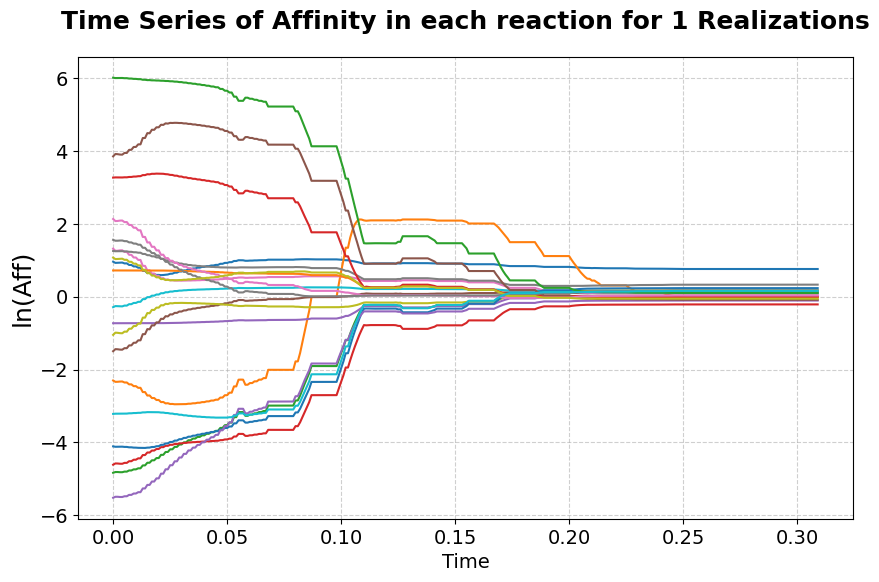

In [31]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")

data = pd.read_csv('C:/Users/Lenovo/Desktop/Invader Coding/output_singleaff/Affinity_1.dat', header=None)
print(data.shape)

print(data.head())

# Extract Time
time = data.iloc[:, 0]

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each species and plot its time series
for i in range(1, data.shape[1]):  
    plt.plot(time, data.iloc[:, i], label=f"Aff{i}")
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Aff)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Specify the output folder
folder_path = output_dir

# Find and sort the "Time_X.dat" files
file_list = glob.glob(os.path.join(folder_path, "Time_*.dat"))
      # file_list = glob.glob(f"{folder_path}/Time_*.dat")

data = pd.read_csv('C:/Users/Lenovo/Desktop/Invader Coding/output_singleaff1/Affinity_1.dat', header=None)
print(data.shape)

print(data.head())

# Extract Time
time = data.iloc[:, 0]

# Create a figure
plt.figure(figsize=(10, 6))

# Loop through each species and plot its time series
for i in range(1, data.shape[1]):  
    plt.plot(time, data.iloc[:, i], label=f"Aff{i}")
        

# Add title and labels
plt.title(f'Time Series of Affinity in each reaction for 1 Realizations', fontsize=18, pad=20, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('ln(Aff)', fontsize=18)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Ensure the "images" folder exists
os.makedirs("./output/images", exist_ok=True)

# Save the figure
plt.savefig("./output/images/Y_time_series.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()